In [ ]:
!pip install kaggle

In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Import Sarcasm Dataset

In [ ]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d tyb001/sarcasm-dataset

Dataset URL: https://www.kaggle.com/datasets/tyb001/sarcasm-dataset
License(s): unknown
  0% 0.00/184k [00:00<?, ?B/s]
100% 184k/184k [00:00<00:00, 89.7MB/s]


In [ ]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/sarcasm-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
!ls

 kaggle.json   sample_data  'Sarcasm Dataset.csv'   sarcasm-dataset.zip


In [ ]:
import pandas as pd
df=pd.read_csv('Sarcasm Dataset.csv')
df

,Unnamed: 0,tweet,sarcastic,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3463,3463,The population spike in Chicago in 9 months is...,0,NaN,NaN,NaN,NaN,NaN,NaN
3464,3464,You'd think in the second to last English clas...,0,NaN,NaN,NaN,NaN,NaN,NaN
3465,3465,I’m finally surfacing after a holiday to Scotl...,0,NaN,NaN,NaN,NaN,NaN,NaN
3466,3466,Couldn't be prouder today. Well done to every ...,0,NaN,NaN,NaN,NaN,NaN,NaN


**Data Cleaning**

In [ ]:
import re # re is regular expression

def preprocess_text(text):
    # Convert the input to a string to handle non-string values
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text) # http\S+ means remove everything which mention after http even space as well

    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)

    # remove emojis, symbols, maps and flags
    text = re.sub(r'[^\x00-\x7F]+', '', text)


    # Remove extra white space
    text = re.sub(r'\s+', ' ', text).strip()

    # remove hastags
    text = re.sub(r'#\S+', '', text)

    # Convert to lowercase
    text = text.lower()

    return text

In [ ]:
df['clean_tweet']=df['tweet'].apply(lambda x: preprocess_text(x))

In [ ]:
print(df['clean_tweet']) # now data is cleaned

0       the only thing i got from college is a caffein...
1       i love it when professors draw a big question ...
2       remember the hundred emails from companies whe...
3       today my poppop told me i was not forced to go...
4       volphancarol littlewhitty mysticalmanatee i di...
                              ...                        
3463    the population spike in chicago in 9 months is...
3464    youd think in the second to last english class...
3465    im finally surfacing after a holiday to scotla...
3466    couldnt be prouder today well done to every st...
3467    overheard as my 13 year old games with a frien...
Name: clean_tweet, Length: 3468, dtype: object


In [ ]:
df.shape

(3468, 10)

In [ ]:
df['sarcasm'].value_counts()

,count
sarcasm,
1.0,713
0.0,154


In [ ]:
# Balance the target variable(sarcasm)

import numpy as np
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler

def balanced_df(df,text,target):
    # Drop rows with NaN values in the target column
    df = df.dropna(subset=[target])  # This line is added to drop NaN
    ros=RandomOverSampler()
    X_resampled,y_resampled=ros.fit_resample(np.array(df[text]).reshape(-1,1),df[target])
    balanced_df=pd.DataFrame({text:X_resampled.ravel(),target:y_resampled})
    return balanced_df

In [ ]:
balanced_df=balanced_df(df,'clean_tweet','sarcasm')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [ ]:
balanced_df['sarcasm'].value_counts() # now target varaible gets balanced

,count
sarcasm,
0.0,713
1.0,713


**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X=df['clean_tweet']
y=df['sarcasm']

# Train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape

(2774,)

In [ ]:
X_test.shape

(694,)

In [ ]:
y_train.shape

(2774,)

In [ ]:
y_test.shape

(694,)

**Downloading pretrained Bert and Tokenizer**

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

model=TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

**Tokenization and encoding (Padding, Truncation, max_length)**

In [ ]:
# padding is all about to get the results in same length
# truncation will cut the length of result to make it as a small length result
# max_length will give the result as per the suggested length

In [ ]:
my_max=max(len(text) for text in balanced_df['clean_tweet'])
my_max # it will show the sentence who have max words

276

In [ ]:
max_length=276
train_encodings=tokenizer(X_train.tolist(),truncation=True,padding=True,max_length=max_length)
test_encodings=tokenizer(X_test.tolist(),truncation=True,padding=True,max_length=max_length)

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((dict(train_encodings),y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((dict(test_encodings),y_test))

**Fine tuning Bert and Training**

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# Train the model
history=model.fit(train_dataset.shuffle(1000).batch(16),epochs=10,batch_size=8,validation_data=test_dataset.batch(16))


Epoch 1/10
174/174 [==============================] - 62s 147ms/step - loss: nan - accuracy: 0.0454 - val_loss: nan - val_accuracy: 0.0447
Epoch 2/10
174/174 [==============================] - 22s 126ms/step - loss: nan - accuracy: 0.0443 - val_loss: nan - val_accuracy: 0.0447
Epoch 3/10
174/174 [==============================] - 22s 125ms/step - loss: nan - accuracy: 0.0443 - val_loss: nan - val_accuracy: 0.0447
Epoch 4/10
174/174 [==============================] - 23s 130ms/step - loss: nan - accuracy: 0.0443 - val_loss: nan - val_accuracy: 0.0447
Epoch 5/10
174/174 [==============================] - 22s 127ms/step - loss: nan - accuracy: 0.0443 - val_loss: nan - val_accuracy: 0.0447
Epoch 6/10
174/174 [==============================] - 23s 130ms/step - loss: nan - accuracy: 0.0443 - val_loss: nan - val_accuracy: 0.0447
Epoch 7/10
174/174 [==============================] - 23s 129ms/step - loss: nan - accuracy: 0.0443 - val_loss: nan - val_accuracy: 0.0447
Epoch 8/10
174/174 [=======

**Train and Val loss**

In [ ]:
history.history

{'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'accuracy': [0.0454217754304409,
  0.04434030130505562,
  0.04434030130505562,
  0.04434030130505562,
  0.04434030130505562,
  0.04434030130505562,
  0.04434030130505562,
  0.04434030130505562,
  0.04434030130505562,
  0.04434030130505562],
 'val_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'val_accuracy': [0.044668588787317276,
  0.044668588787317276,
  0.044668588787317276,
  0.044668588787317276,
  0.044668588787317276,
  0.044668588787317276,
  0.044668588787317276,
  0.044668588787317276,
  0.044668588787317276,
  0.044668588787317276]}

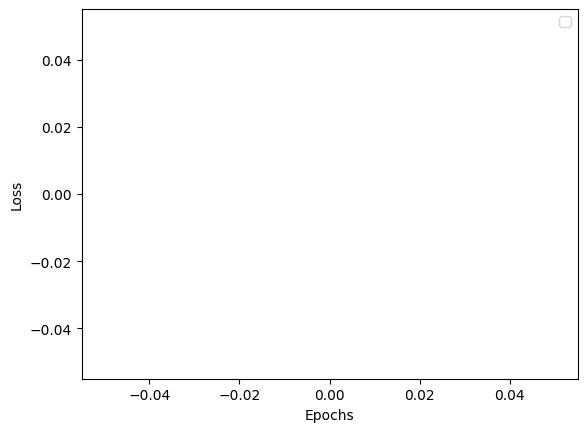

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
y_probabs=model.predict(test_dataset.batch(16))
y_pred=np.argmax(y_probabs.logits,axis=1)

y_pred

44/44 [==============================] - 2s 45ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
#confusion_matrix(y_test,y_pred)

In [ ]:
#classification_report(y_test,y_pred)

In [ ]:
# save and load the model

model.save_pretrained('sarcasm_model')
tokenizer.save_pretrained('sarcasm_model')
